In [19]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [9]:
df = joblib.load('./dataframes/final_all.pkl')

In [10]:
#exclude year 2009 since it is considered using t-1 columns

df = df[df['year']>=2010].copy()

In [11]:
#create individual dataframe for each year

years = [y for y in range(2010, 2020)]

dataframes = {}

for year in years:
    dataframes[f'df_{year}'] = df[df['year']==year]

In [74]:
dataframes['df_2019'].shape

(138, 160)

### Creating Clean Dataframe Class

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [13]:
class CleanDataframe():
    def __init__(self, _df):
        self.df = _df
        self.df_categorized = self.categorize()
        self.df_scaled = self.scaling()
        self.df_pca = self.pca()
        
    
    def categorize(self):
        dummies = pd.get_dummies(self.df['urban_style'])
        df_categorized = pd.concat([self.df, dummies], axis=1)
        df_categorized.drop('urban_style', axis=1, inplace=True)
        df_categorized.rename(columns={'Einfamilienhausgebiete': 'urban_style_family',
                                'Großsiedlungen der 60er - 80er Jahre': 'urban_style_60s',
                                'Siedlungsbau der 20er - 30er Jahre': 'urban_style_20s',
                                'Siedlungsbau der 50er Jahre': 'urban_style_50s',
                                'Siedlungsbau der 90er - 2000er Jahre': 'urban_style_90s',
                                'Verdichtete Blockrandbebauung': 'urban_style_old'
                               }, inplace=True)
        return df_categorized
        
        
    def scaling(self):
        self.df_categorized.fillna(0, inplace=True)
        
        features = self.df_categorized.columns.drop(['Bezirk', 'Bezirksregion', 'LOR', 'Bezirksname',
                                                     'year', 'PLZ', 'total_Bezirk', 'perc_Bezirk_total',
                                                     'total_Bezirk_t-1', 'perc_Bezirk_total_t-1',])
        # Separating out the features
        df_scaled = self.df_categorized.loc[:, features].values
        # Standardizing the features
        df_scaled = StandardScaler().fit_transform(df_scaled)
        return df_scaled
    
    
    def pca(self):
        pca = PCA(n_components=2)
        principalComponents = pca.fit_transform(self.df_scaled)
        df_pca = pd.DataFrame(data = principalComponents,
                              columns = ['pc_1', 'pc_2'])
        return df_pca

### Gaussian Mixture Model - Choosing number of components K

In [14]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [16]:
#finding the best cv_type/compontents combination for each year

eval_dict = {}
for key in dataframes.keys():
    bic = {}
    for i in tqdm(range(100)):
        X = CleanDataframe(dataframes[key]).df_scaled
        
        n_components_range = range(4, 8)
        cv_types = ['spherical', 'tied', 'diag', 'full']
        lowest_bic = np.infty
        for cv_type in cv_types:
            for n_components in n_components_range:
                # Fit a Gaussian mixture with EM
                gmm = GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
                gmm.fit(X)
                
                if gmm.bic(X) < lowest_bic:
                    lowest_bic = gmm.bic(X)
                    best_n_components  = n_components
                    best_cv_type = cv_type
                    
                if '_'.join([best_cv_type, str(best_n_components)]) in bic.keys():
                    bic['_'.join([best_cv_type, str(best_n_components)])] += 1
                else:
                    bic['_'.join([best_cv_type, str(best_n_components)])] = 1
            
    eval_dict[key] = bic

100%|██████████| 100/100 [00:32<00:00,  3.07it/s]


In [17]:
import pprint

pprint.pprint(eval_dict)

{'df_2010': {'spherical_4': 109,
             'spherical_5': 108,
             'spherical_6': 114,
             'spherical_7': 69,
             'tied_4': 596,
             'tied_5': 196,
             'tied_6': 192,
             'tied_7': 216},
 'df_2011': {'spherical_4': 105,
             'spherical_5': 112,
             'spherical_6': 101,
             'spherical_7': 82,
             'tied_4': 618,
             'tied_5': 158,
             'tied_6': 163,
             'tied_7': 261},
 'df_2012': {'spherical_4': 106,
             'spherical_5': 100,
             'spherical_6': 112,
             'spherical_7': 82,
             'tied_4': 516,
             'tied_5': 250,
             'tied_6': 164,
             'tied_7': 270},
 'df_2013': {'spherical_4': 106,
             'spherical_5': 105,
             'spherical_6': 116,
             'spherical_7': 73,
             'tied_4': 619,
             'tied_5': 173,
             'tied_6': 192,
             'tied_7': 216},
 'df_2014': {'spherical_

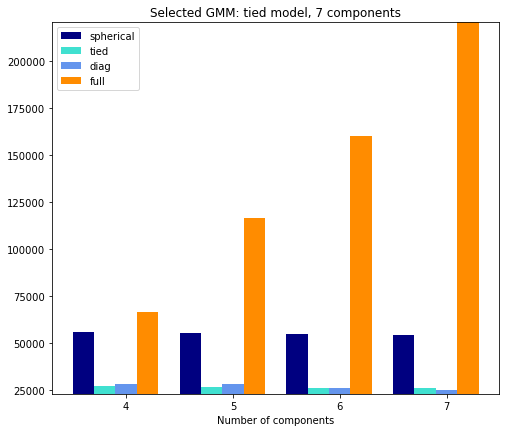

In [33]:
import itertools

X = CleanDataframe(dataframes['df_2019']).df_scaled

bic = []
n_components_range = range(4, 8)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=n_components,
                              covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
plt.xlabel('Number of components')
plt.legend([b[0] for b in bars], cv_types)

plt.title('Selected GMM: tied model, 7 components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

In [22]:
import plotly.express as px
import plotly.graph_objects as go

In [91]:
class Cluster(CleanDataframe):
    def __init__(self, _df, _n_clusters, _clustering_method):
        CleanDataframe.__init__(self, _df)
        self.n_clusters = _n_clusters
        self.clustering_method = _clustering_method
        if self.clustering_method == 'k_means':
            self.clusters, self.cluster_centers = self.k_means_clustering()
        else:
            self.clusters, self.bic = self.gaussian_clustering()
        
    def k_means_clustering(self):
        X = self.df_scaled
        kmeans = KMeans(n_clusters=self.n_clusters)
        kmeans.fit(X)
        clusters = kmeans.predict(X)
        cluster_centers = pd.DataFrame(kmeans.fit(self.df_pca).cluster_centers_)
        return clusters, cluster_centers
    
    
    def gaussian_clustering(self):
        X = self.df_scaled
        gaussian = GaussianMixture(n_components=self.n_clusters,
                                   covariance_type='tied',
                                   random_state=42)
        gaussian.fit(X)
        clusters = gaussian.predict(X)
        bic = gaussian.bic(X)
        return clusters, bic
    
    def visualize_clusters(self):
        viz_df = pd.concat([self.df_categorized[['Bezirk', 'Bezirksname']].reset_index(),
                            self.df_pca,
                            pd.Series(self.clusters, name='cluster')],
                           axis=1)
        fig = px.scatter(viz_df,
                        x='pc_1',
                        y='pc_2',
                        color='cluster',
                        hover_name='Bezirksname',
                        hover_data=['Bezirk'],
                        #range_x=[-20, 40],
                        #range_y=[-10, 25]
                        )
        fig.update_traces(marker=dict(size=10))

        if self.clustering_method == 'k_means':
            fig.add_trace(
                go.Scatter(
                    x=self.cluster_centers.iloc[:, 0],
                    y=self.cluster_centers.iloc[:, 1],
                    mode="markers",
                    marker=dict(size=15,
                                 color='DarkSlateGrey',
                                 opacity=0.2
                                ),
                    showlegend=False
                )
            )
        fig.show()

In [69]:
cluster_2019 = Cluster(dataframes['df_2019'], 7, 'gaussian')
cluster_2019.visualize_clusters()

### K-Means - Choosing number of clusters K (Silhouette Score)

In [70]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [79]:
centers.mean(axis=1)

0   -0.114057
1   -0.051715
2   -0.197478
3    0.215077
4    0.154152
5    0.279009
6   -0.140509
7   -0.040331
dtype: float64

For n_clusters = 4 The average silhouette_score is : 0.11212705982525363
For n_clusters = 5 The average silhouette_score is : 0.12460795035202334
For n_clusters = 6 The average silhouette_score is : 0.12335714545494414
For n_clusters = 7 The average silhouette_score is : 0.1130708314279361
For n_clusters = 8 The average silhouette_score is : 0.09633855114662708


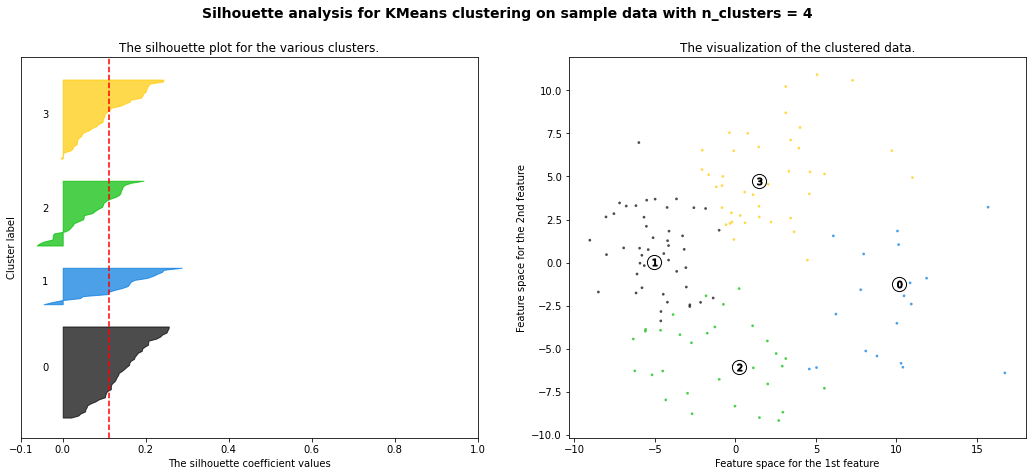

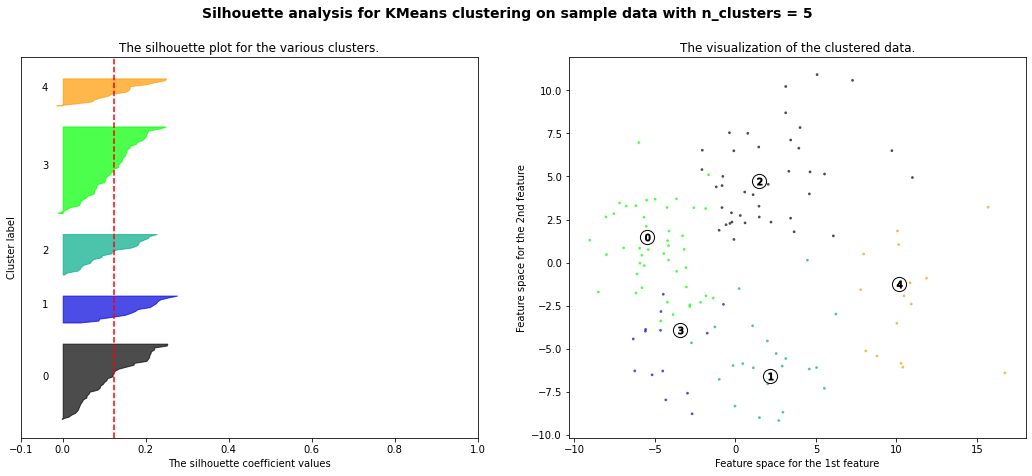

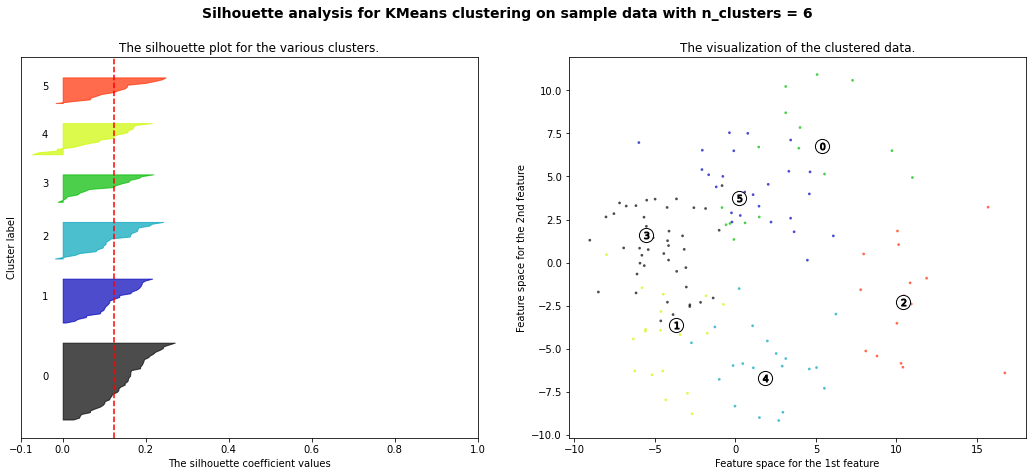

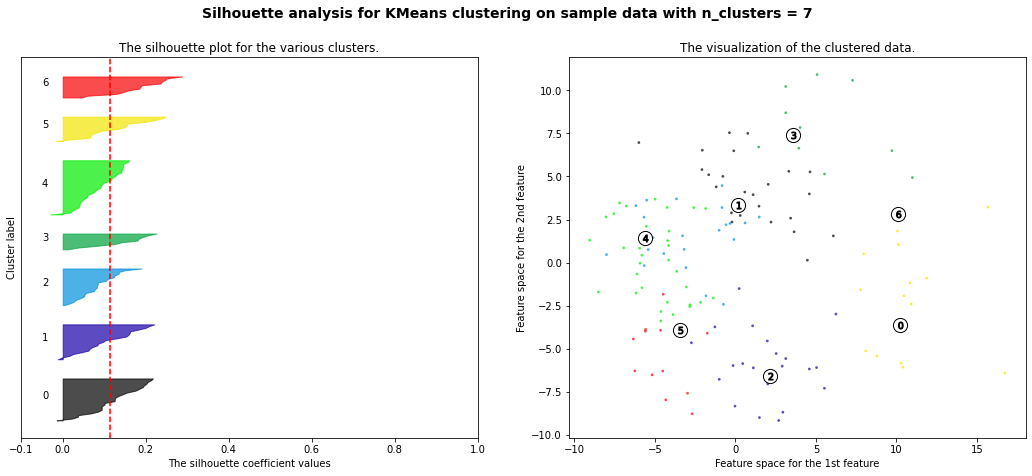

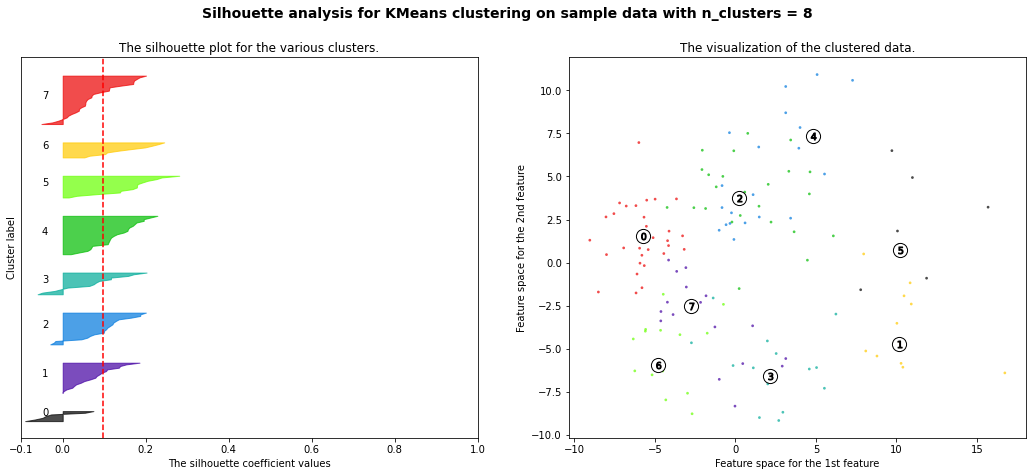

In [89]:
range_n_clusters = [4, 5, 6, 7, 8]
X = CleanDataframe(dataframes['df_2019'])

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(cluster.df_scaled) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X.df_scaled)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X.df_scaled, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X.df_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(cluster.df_pca.iloc[:, 0],
                cluster.df_pca.iloc[:, 1],
                marker='.',
                s=30,
                lw=0,
                alpha=0.7,
                c=colors,
                edgecolor='k')


    # Labeling the clusters
    clusterer.fit_predict(X.df_pca)
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [92]:
cluster_2019 = Cluster(dataframes['df_2019'], 5, 'k_means')
cluster_2019.visualize_clusters()